Using TensorFlow backend.
[2017-05-18 22:54:08,493] Making new env: CartPole-v1


episode: 0   score: 18.0   memory length: 19   epsilon: 0.9811700348643991
episode: 50   score: 91.0   memory length: 1895   epsilon: 0.1501758809449194
episode: 100   score: 311.0   memory length: 5000   epsilon: 0.009998671593271896
episode: 150   score: 190.0   memory length: 5000   epsilon: 0.009998671593271896
episode: 200   score: 306.0   memory length: 5000   epsilon: 0.009998671593271896
episode: 250   score: 500.0   memory length: 5000   epsilon: 0.009998671593271896


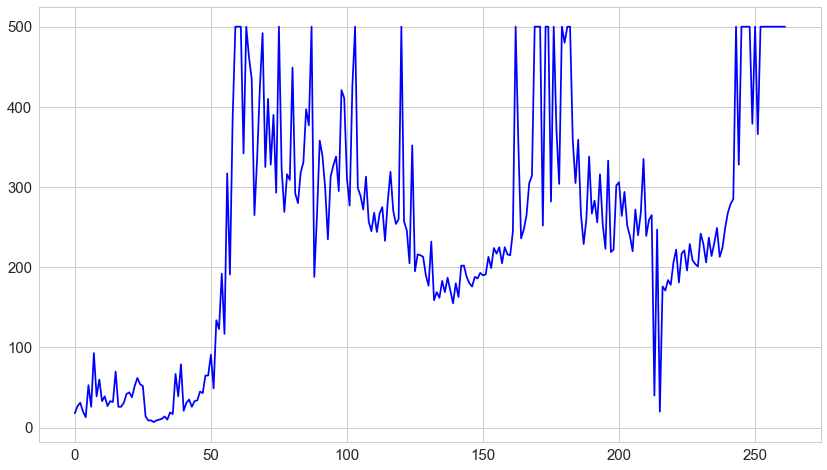

In [1]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

MAX_EPISODES = 500

class DQNAgent:
    def __init__(self, state_size, action_size):

        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        
        self.memory = deque(maxlen=5000)

        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        # TODO implement model
        raise NotImplementedError

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * np.amax(target_val[i])

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

def train():
    
    scores, episodes = [], []

    for e in range(MAX_EPISODES):
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False    
        while not done:

            # get action for the current state and go one step in environment
            action = agent.choose_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100

            # save the sample <s, a, r, s'> to the replay memory
            agent.remember(state, action, reward, next_state, done)
            # every time step do the training
            agent.learn()
            score += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                
                if e % 50 == 0:
                
                    print("episode:", e, "  score:", score, "  memory length:", len(agent.memory),
                          "  epsilon:", agent.epsilon)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    plt.plot(episodes, scores, 'b')
                    return
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
train()

In [4]:
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [5]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [6]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

state = env.reset()
state = np.reshape(state, [1, state_size])
done = False
frames = []
while not done:
    frames.append(env.render(mode='rgb_array'))
    action = agent.choose_action(state)
    state, reward, done, info = env.step(action)
    state = np.reshape(state, [1, state_size])

<IPython.core.display.Javascript object>


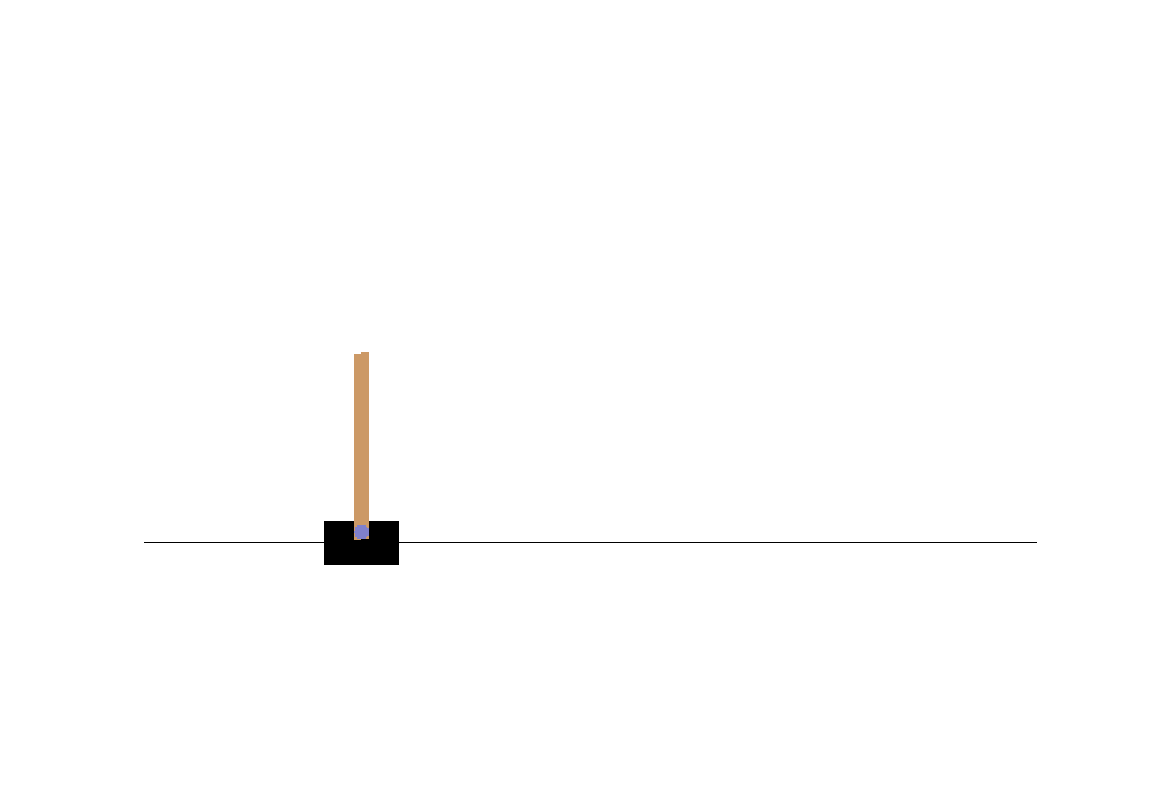

In [7]:
video = plot_animation(frames);